In [3]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
%matplotlib notebook
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import astropy
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.coordinates import SkyOffsetFrame
import astropy.units as u
cosmo = FlatLambdaCDM(H0=75. * u.km / u.s / u.Mpc, Om0=0.31)
c = 299792.458
from ellipsoid import*
from ellipsoid_fit import*

Reading CF4 density, velocity, and associated errors https://projets.ip2i.in2p3.fr//cosmicflows/ https://arxiv.org/abs/2211.16390

In [4]:
hdu = fits.open('CF4gp_new_64-z008_velocity.fits')
hdu_d = fits.open('CF4gp_new_64-z008_delta.fits')
hdu_e = fits.open('CF4gp_new_64-z008_velocity_cube_error.fits')

multiply by 52 the velocity values and associated errors https://projets.ip2i.in2p3.fr//cosmicflows/

In [15]:
t = 52.*hdu[0].data
t_e = 52.*hdu_e[0].data
t_d = hdu_d[0].data
np.shape(t_e)

(64, 64, 64)

This function reads an OBJ file and extracts the vertex, face, and line information. It converts the data into NumPy arrays, making it easier to work with

In [12]:
def load_obj(filename):
    vertices = []
    faces = []
    lines = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('v '):
                vertices.append(list(map(float, line[2:].strip().split())))
            elif line.startswith('f '):
                face = list(map(int, line[2:].strip().split()))
                faces.append([i-1 for i in face])
            elif line.startswith('l '):
                line = list(map(int, line[2:].strip().split()))
                lines.append([i-1 for i in line])
    return np.array(vertices), np.array(faces), np.array(lines)

Now read the OBJ file for the Laniakea enveloppe: https://sketchfab.com/3d-models/cf4-new-128-z008-watershed-laniakea-b5064f86dcd44277996f758da3cd0349 https://arxiv.org/abs/2305.02339

In [13]:
vertices, faces, lines = load_obj('laniakea.obj')

In [14]:
Lania = pd.DataFrame(vertices, columns=['X','Y','Z'])
Lania

,X,Y,Z
0,-7.8125,0.0000,-62.5000
1,0.0000,0.0000,-62.5000
2,-7.8125,7.8125,-62.5000
3,0.0000,7.8125,-62.5000
4,-7.8125,0.0000,-54.6875
...,...,...,...
3453,-54.6875,-54.6875,187.5000
3454,-46.8750,-54.6875,187.5000
3455,-70.3125,-46.8750,187.5000
3456,-62.5000,-46.8750,187.5000


Given that the velocity field is a 64^3 grid of +/- 500 Mpc/h100. I convert the Laniakea positions to that grid to make it easier to predict velocities for all points at once

In [17]:
u = Lania["X"]
v = Lania["Y"]
w = Lania["Z"]
ii = np.rint(np.round(32. + ((64./1000.)*u),0)).astype(int)
jj = np.rint(np.round(32. + ((64./1000.)*v),0)).astype(int)
kk = np.rint(np.round(32. + ((64./1000.)*w),0)).astype(int)
#that's the Laniakea velocity field
lania_vv = t[:,kk,jj,ii]

Write the positons and velocities as a DataFrame to make it easier to work with

In [18]:
lania_cf4 = pd.DataFrame(np.column_stack((u,v,w,lania_vv[2],lania_vv[1],lania_vv[0])),columns=["SGX","SGY","SGZ","vx","vy","vz"])
lania_cf4

,SGX,SGY,SGZ,vx,vy,vz
0,-7.8125,0.0000,-62.5000,198.023834,173.473755,-55.513783
1,0.0000,0.0000,-62.5000,198.023834,173.473755,-55.513783
2,-7.8125,7.8125,-62.5000,198.023834,173.473755,-55.513783
3,0.0000,7.8125,-62.5000,198.023834,173.473755,-55.513783
4,-7.8125,0.0000,-54.6875,198.023834,173.473755,-55.513783
...,...,...,...,...,...,...
3453,-54.6875,-54.6875,187.5000,-228.536102,25.211275,222.808090
3454,-46.8750,-54.6875,187.5000,-229.369263,-9.903706,213.526794
3455,-70.3125,-46.8750,187.5000,-274.572876,17.027435,212.022064
3456,-62.5000,-46.8750,187.5000,-274.572876,17.027435,212.022064


In [19]:
lania_cf4.to_csv("new_laniakea_cf4_velocities.csv", index = False, header = True)

The given function ellipsoid_fit(X) is taken from https://github.com/aleksandrbazhin/ellipsoid_fit_python. This function performs an ellipsoid fitting to a set of 3D points represented by the input array X. 

Here's a description and summary of the function:

1. The function takes an input array X containing 3D points, where each row represents a point and each column represents the coordinate in the x, y, and z directions.

2. The function extracts the x, y, and z coordinates from X using slicing and assigns them to variables x, y, and z, respectively.

3. It constructs a matrix D that represents a linear system of equations for fitting an ellipsoid. Each row of D corresponds to an equation involving the x, y, and z coordinates of the points.

4. It calculates the right-hand side of the linear least squares problem (d2) by summing the squared x, y, and z coordinates.

5. The function solves the linear system of equations D.dot(D.T).dot(u) = D.dot(d2) for u, which represents the parameters of the ellipsoid.

6. It calculates the ellipsoid's semi-axis lengths a, b, and c based on the parameters u.

7. The function constructs a matrix A based on the ellipsoid parameters, representing the quadratic form of the ellipsoid equation.

8. It solves a linear system of equations to find the center of the ellipsoid.

9. It constructs a translation matrix to move the ellipsoid's center to the origin.

10. The function applies the translation matrix to A to obtain the rotated ellipsoid.

11. It calculates the eigenvalues and eigenvectors of the rotated ellipsoid's quadratic form matrix.

12. The eigenvalues represent the inverse square radii of the ellipsoid along the principal axes.

13. The eigenvectors represent the directions of the ellipsoid's principal axes.

14. The function scales the radii by the sign of the corresponding eigenvalues and returns the center, eigenvectors, radii, and the ellipsoid parameters.

In summary, this function fits an ellipsoid to a set of 3D points by solving a linear least squares problem and extracting the center, eigenvectors, and radii of the ellipsoid. It provides a way to estimate the shape and orientation of an ellipsoidal structure that best represents the given set of points.

In [26]:
ellipsoid = ellipsoid_fit(vertices)

In [42]:
center = ellipsoid[0]

axes = ellipsoid[2]

R = ellipsoid[1]

The function performs the following steps to check the solution:

1. Subtract the center of the ellipsoid from each point to make the ellipsoid centered at the origin.
2. Create a transformation matrix that will rotate the points so that the bulges of the ellipsoid are aligned with the axes (no xy, xz, or yz terms), and then scale the points by the inverse of the axes gains.
3. Apply the transformation matrix to the points.
4. Calculate the distance from the origin for each point (which should ideally be 1.0). The function then outputs the average radius and standard deviation of the radii of the transformed points, which can be used to evaluate the accuracy of the fitted ellipsoid.
5.In general, a good fit of an ellipsoid to a set of points should result in radii that are close to 1 and a low standard deviation. However, the specific values that can be considered as indicating a good fit depend on the context and the tolerance for errors.

For example, in some applications, a radius within 10% of 1 (i.e., between 0.9 and 1.1) may be considered a good fit. In other applications, a more stringent criterion may be required, such as a radius within 5% of 1 (i.e., between 0.95 and 1.05).

Similarly, the acceptable range of standard deviation may also depend on the context and the required accuracy of the fit. In general, a lower standard deviation indicates a more precise fit. However, what is an acceptable standard deviation can depend on the specifics of the application.

Therefore, the values that indicate a good fit should be determined based on the context and the specific requirements of the application.

In [40]:
check01 = printAns3D(center,axes,R,vertices[:,0],vertices[:,1],vertices[:,2],"True")


Center at     -9.2335,  -47.0633,   85.0857
Axes gains    48.6154,  128.7463,  166.3854 
Rotation Matrix
   0.25957,   0.81427,   0.51922
   0.92221,  -0.36857,   0.11698
  -0.28662,  -0.44847,   0.84660

Transformation Matrix
 [[0.00848546 0.00248008 0.00215182]
 [0.00248008 0.01590222 0.00607978]
 [0.00215182 0.00607978 0.0099593 ]]

Average Radius      0.9723 (truth is 1.0)
Stdev of Radius     0.2339
 


This code generates a 3D plot of an ellipsoid, including the original data points, the fitted ellipsoid surface, the center, and the principal axes. It provides a visualization of the ellipsoid's shape, orientation, and position relative to the original data points.

<IPython.core.display.Javascript object>


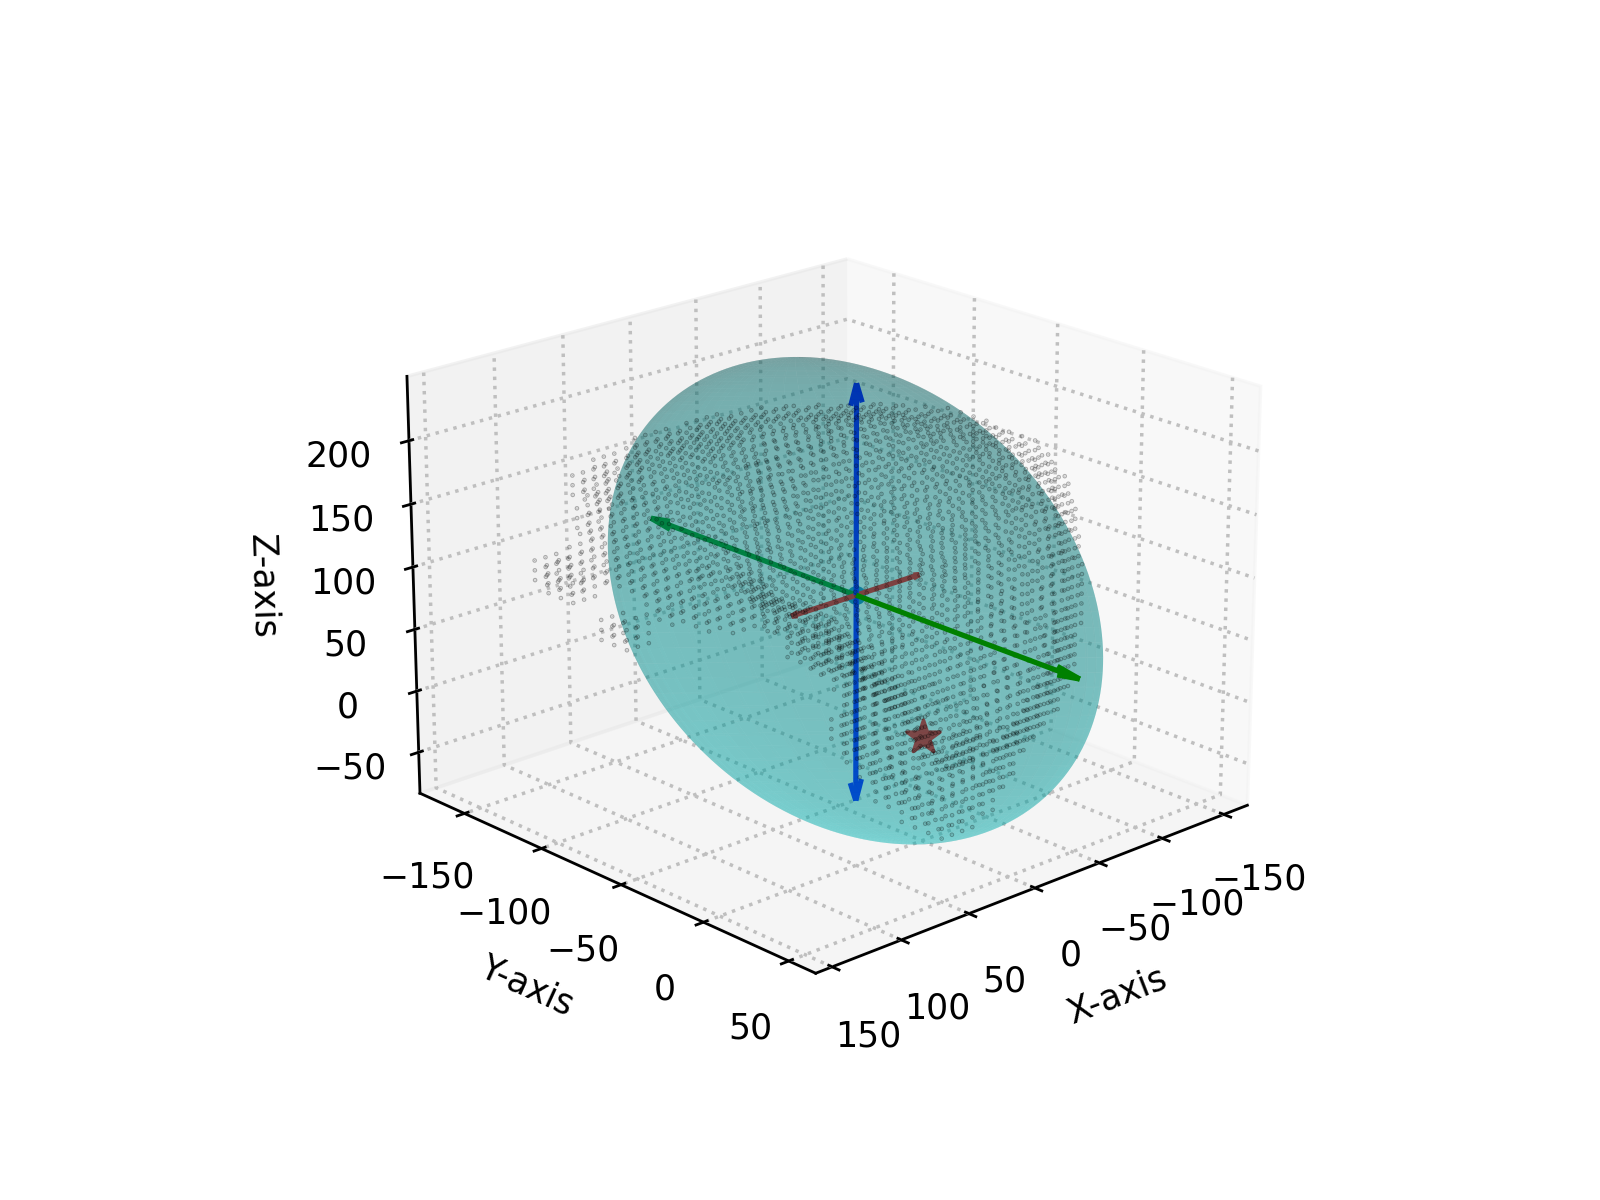

In [41]:
uu = np.linspace(0, 2 * np.pi, 100)
vv = np.linspace(0, np.pi, 100)
x = axes[0] * np.outer(np.cos(uu), np.sin(vv))
y = axes[1] * np.outer(np.sin(uu), np.sin(vv))
z = axes[2] * np.outer(np.ones_like(uu), np.cos(vv))

for i in range(len(x)):
    for j in range(len(x)):
        [x[i,j], y[i,j], z[i,j]] = np.dot([x[i,j], y[i,j], z[i,j]], R) + center

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lania_cf4.SGX,lania_cf4.SGY,lania_cf4.SGZ,s=0.1,alpha=0.3,c='k')
ax.plot_surface(x, y, z, color='c', alpha=0.3)
ax.scatter(center[0],center[1],center[2])
ax.scatter(0,0,0,color="red",marker='*',s=100)
ax.quiver(center[0], center[1], center[2], axes[0]*-1.0, 0, 0, color='r', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], 0, axes[1]*-1.0, 0, color='g', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], 0, 0, axes[2]*-1.0, color='b', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], axes[0], 0, 0, color='r', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], 0, axes[1], 0, color='g', length=1.0, arrow_length_ratio=0.1)
ax.quiver(center[0], center[1], center[2], 0, 0, axes[2], color='b', length=1.0, arrow_length_ratio=0.1)
#ax.grid(False)
#ax.axis('off') # Remove the axes
ax.xaxis._axinfo["grid"].update({"linewidth":1, "color" : "0.75","linestyle" :":"})
ax.yaxis._axinfo["grid"].update({"linewidth":1, "color" : "0.75","linestyle" :":"})
ax.zaxis._axinfo["grid"].update({"linewidth":1, "color" : "0.75","linestyle" :":"})
#ax.grid(b=True, color='0.05',linestyle=':')
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.savefig('new_ellipsoid.png', dpi=300)
plt.show()